In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict,RandomizedSearchCV
from xgboost import XGBRegressor
import xgboost as xgb

In [2]:
df_train = pd.read_csv('Dataset for the project/train/train.csv')
df_test = pd.read_csv('Dataset for the project/test/test.csv')
print('Train shape:',df_train.shape)
print('Test shape:',df_test.shape)

Train shape: (4209, 378)
Test shape: (4209, 377)


In [3]:
df_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


# Checking for Null values

In [5]:
print('Number of Null Values in Training data:',np.sum(df_train.isnull().sum()))
print('Number of Null Values in Testing data:',np.sum(df_test.isnull().sum()))

Number of Null Values in Training data: 0
Number of Null Values in Testing data: 0


No Null Values in training data and Testing Data.

# Checking for unique values

In [6]:
dtype_data=df_train.dtypes.reset_index() # Different data types in training data
dtype_data.columns = ["Count", "Column Type"]
dtype_data.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [7]:
print(df_train.dtypes)
categ_columns = df_train.columns[df_train.dtypes=='object']
print('Categorical features:')
print(categ_columns)

ID        int64
y       float64
X0       object
X1       object
X2       object
         ...   
X380      int64
X382      int64
X383      int64
X384      int64
X385      int64
Length: 378, dtype: object
Categorical features:
Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')


In [8]:
print('No. of unique values in categorical columns:')
print(df_train.loc[:,categ_columns].nunique())

No. of unique values in categorical columns:
X0    47
X1    27
X2    44
X3     7
X4     4
X5    29
X6    12
X8    25
dtype: int64


# 'y' is the target variable, therefore we should do some analysis on the target variable.

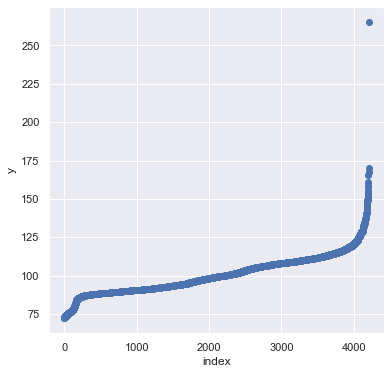

In [9]:
sns.set()
plt.figure(figsize=(6,6))
plt.scatter(range(df_train.shape[0]),np.sort(df_train.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

- A single data point is well above the rest.
- Now let's try to plot the distribution graph.

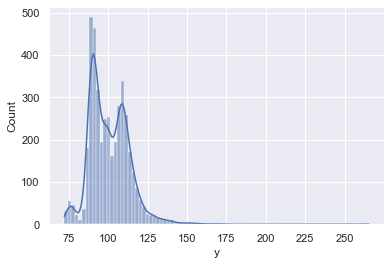

In [10]:
sns.histplot(x='y',data=df_train,kde=True)
plt.show()

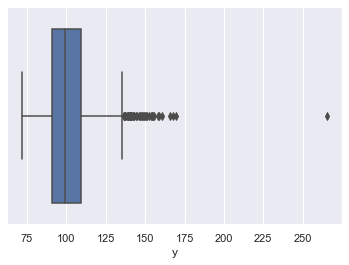

In [11]:
sns.boxplot(x='y',data=df_train)
plt.show()

A single data point is well above the rest.

In [12]:
# features with values [0,1].
non_categ_columns = df_train.columns[(df_train.dtypes=='int64') & (df_train.nunique()==2)]
print('Non categorical features:')
print(non_categ_columns)

Non categorical features:
Index(['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=356)


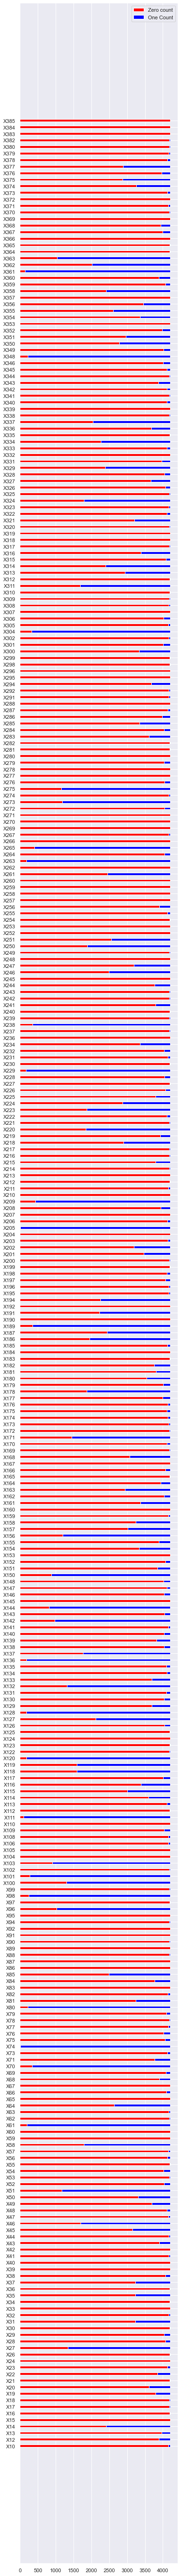

In [13]:
zero_list=[]
one_list=[]
col_list = non_categ_columns.to_list()
for col in col_list:
    zero_list.append((df_train[col]==0).sum())
    one_list.append((df_train[col]==1).sum())
l = len(col_list)
arr = np.arange(l)
width = 0.35
plt.figure(figsize=(6,100))
plot_1 = plt.barh(arr, zero_list, width, color='red')
plot_2 = plt.barh(arr, one_list, width, left=zero_list, color="blue")
plt.yticks(arr, col_list)
plt.legend((plot_1[0], plot_2[0]), ('Zero count', 'One Count'))
plt.show()


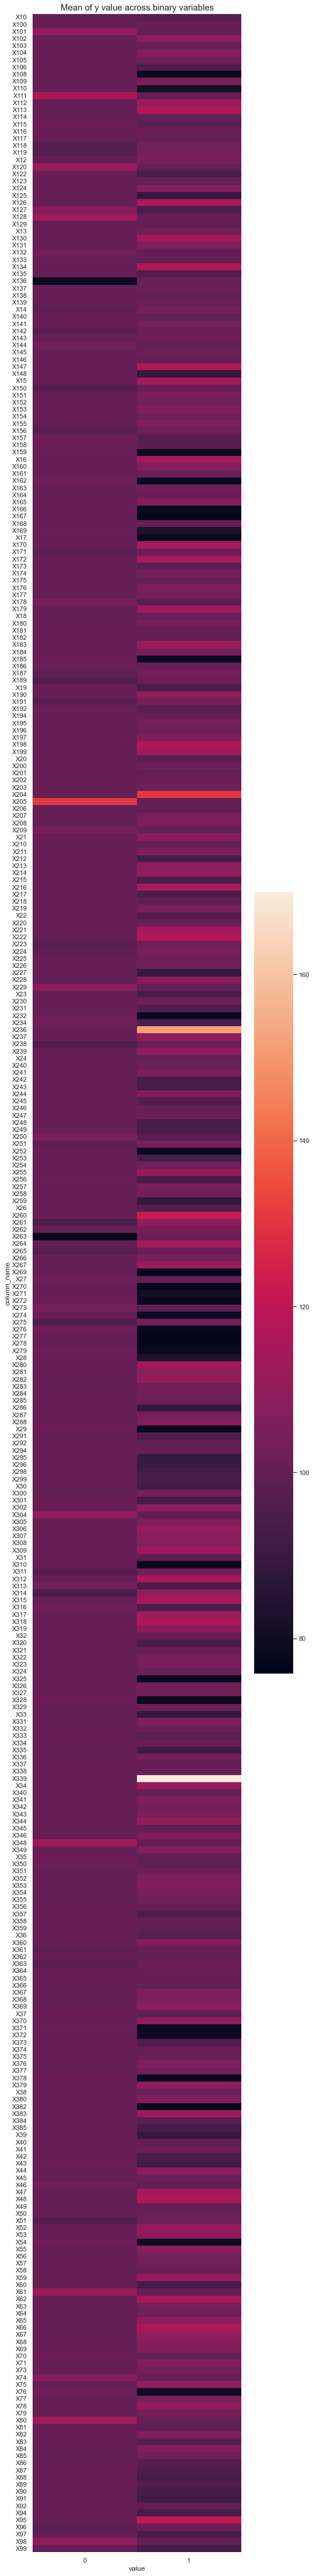

In [14]:
zero_mean_list = []
one_mean_list = []
cols_list = non_categ_columns.to_list()
for col in cols_list:
    zero_mean_list.append(df_train.loc[df_train[col]==0].y.mean())
    one_mean_list.append(df_train.loc[df_train[col]==1].y.mean())
new_df_1 = pd.DataFrame({"column_name":cols_list+cols_list, "value":[0]*len(cols_list) + [1]*len(cols_list), "y_mean":zero_mean_list+one_mean_list})
new_df = new_df_1.pivot('column_name', 'value', 'y_mean')

plt.figure(figsize=(8,80))
sns.heatmap(new_df)
plt.title("Mean of y value across binary variables", fontsize=15)
plt.show()

<h3>Binary variables that show a good color difference in the above graphs between 0 and 1 
are likely to be more predictive given the the count distribution is also good between 
both the classes (can be seen from the previous graph)</h3>

# Dropping columns with 0 variance

In [15]:
y = df_train.y
df_train.drop(columns=['ID','y'],inplace=True)
test_id = df_test['ID']
df_test.drop(columns=['ID'],inplace=True)

In [16]:
X_cat = df_train.loc[:,categ_columns]
X_num = df_train.loc[:,df_train.dtypes!='object']
X_test_cat = df_test.loc[:,categ_columns]
X_test_num = df_test.loc[:,df_train.dtypes!='object']

In [17]:
Num_cols_to_drop = np.sum(X_num.var()==0)
print('Number of columns to drop:',Num_cols_to_drop)
cols_to_drop = np.array(X_num.columns[X_num.var()==0])
print('Columns to be dropped:',cols_to_drop)

Number of columns to drop: 12
Columns to be dropped: ['X11' 'X93' 'X107' 'X233' 'X235' 'X268' 'X289' 'X290' 'X293' 'X297'
 'X330' 'X347']


In [18]:
X_num_fe = X_num.drop(columns=cols_to_drop)
X_test_num_fe = X_test_num.drop(columns=cols_to_drop)

In [19]:
print('Shape of training data after feature engineering:',X_num_fe.shape)
print('Shape of training data after feature engineering:',X_test_num_fe.shape)

Shape of training data after feature engineering: (4209, 356)
Shape of training data after feature engineering: (4209, 356)


In [20]:
X_num_fe.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_test_num_fe.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Label Encoding

In [22]:
le = LabelEncoder()
X_cat = X_cat.apply(lambda x: le.fit_transform(x))
X_test_cat = X_test_cat.apply(lambda x: le.fit_transform(x))

In [23]:
X_cat

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13
...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16
4205,31,16,40,3,3,0,7,7
4206,8,23,38,0,3,0,6,4
4207,9,19,25,5,3,0,11,20


In [24]:
X_test_cat

,X0,X1,X2,X3,X4,X5,X6,X8
0,21,23,34,5,3,26,0,22
1,42,3,8,0,3,9,6,24
2,21,23,17,5,3,0,9,9
3,21,13,34,5,3,31,11,13
4,45,20,17,2,3,30,8,12
...,...,...,...,...,...,...,...,...
4204,6,9,17,5,3,1,9,4
4205,42,1,8,3,3,1,9,24
4206,47,23,17,5,3,1,3,22
4207,7,23,17,0,3,1,2,16


# Dimentionality Reductiona(PCA)

In [25]:
X = np.concatenate([X_cat,X_num_fe],axis=1) # Creating training and validation  data for model creation
X_test = np.concatenate([X_test_cat,X_test_num_fe],axis=1)
print('Shape training data:',X.shape)
print('Shape of testing data:',X_test.shape)

Shape training data: (4209, 364)
Shape of testing data: (4209, 364)


In [26]:
X

array([[32, 23, 17, ...,  0,  0,  0],
       [32, 21, 19, ...,  0,  0,  0],
       [20, 24, 34, ...,  0,  0,  0],
       ...,
       [ 8, 23, 38, ...,  0,  0,  0],
       [ 9, 19, 25, ...,  0,  0,  0],
       [46, 19,  3, ...,  0,  0,  0]], dtype=int64)

In [27]:
X_test

array([[21, 23, 34, ...,  0,  0,  0],
       [42,  3,  8, ...,  0,  0,  0],
       [21, 23, 17, ...,  0,  0,  0],
       ...,
       [47, 23, 17, ...,  0,  0,  0],
       [ 7, 23, 17, ...,  0,  0,  0],
       [42,  1,  8, ...,  0,  0,  0]], dtype=int64)

In [28]:
pca = PCA(n_components=72)
X = pca.fit_transform(X)
X_test = pca.transform(X_test)

In [29]:
pca_train_X_variation = np.round(pca.explained_variance_ratio_.cumsum()*100,decimals=1)
pca_train_X_variation

array([38.3, 59.7, 73. , 84.8, 94. , 95.6, 96.4, 96.8, 97.1, 97.3, 97.6,
       97.8, 97.9, 98.1, 98.2, 98.3, 98.4, 98.5, 98.6, 98.6, 98.7, 98.8,
       98.8, 98.9, 98.9, 99. , 99. , 99.1, 99.1, 99.1, 99.2, 99.2, 99.2,
       99.2, 99.3, 99.3, 99.3, 99.3, 99.4, 99.4, 99.4, 99.4, 99.4, 99.5,
       99.5, 99.5, 99.5, 99.5, 99.5, 99.5, 99.6, 99.6, 99.6, 99.6, 99.6,
       99.6, 99.6, 99.6, 99.6, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7,
       99.7, 99.7, 99.7, 99.7, 99.7, 99.8])

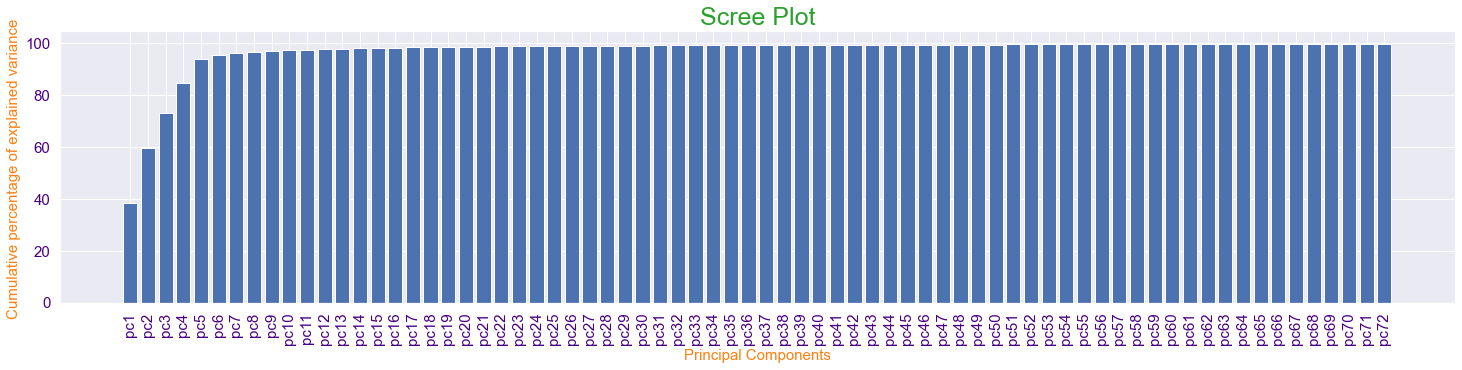

In [30]:
labels  = ['pc'+ str(x) for x in range(1,len(pca_train_X_variation)+1)]

plt.figure(figsize=(25,5))
plt.bar(labels,pca_train_X_variation)
plt.xticks(rotation=90, color='indigo', size=15)
plt.yticks(rotation=0, color='indigo', size=15)
plt.title('Scree Plot',color='tab:green', fontsize=25)
plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
plt.show()

In [31]:
pca_fit_transform_train_X_72_df = pd.DataFrame(X,columns=labels)
pca_fit_transform_train_X_72_df.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc63,pc64,pc65,pc66,pc67,pc68,pc69,pc70,pc71,pc72
0,0.614765,-0.133009,15.624460,3.687564,1.359574,-2.691417,3.816741,1.537687,-0.647686,1.737523,...,-0.432486,0.579342,-0.812864,0.020463,0.506205,-0.407037,0.792439,-0.163083,0.326219,-0.118431
1,0.565407,1.560333,17.909581,-0.092902,1.536648,-4.442877,-0.796540,0.812571,-0.789268,-0.136565,...,-0.134684,0.075531,0.592376,0.227001,0.509878,0.019168,0.231758,0.256369,0.151839,0.013655


In [32]:
pca.components_.shape

(72, 364)

# Model Creation

In [33]:
xgb_r = XGBRegressor()

params={ 'learning_rate'   : [0.01,0.05,0.1,1] ,
         'max_depth'       : [2,3,5,10],
         'min_child_weight': [ 0, 1, 3],
         'n_estimators'    : [100,150,200,500],
         'gamma'           : [1e-2,1e-3,0,0.1,0.01,0.5,1],
         'colsample_bytree': [0.1,0.5,0.7,1],
         'subsample'       : [0.2,0.3,0.5,1],
         'reg_lambda'      : [0,1,10],
         'reg_alpha'       : [1e-5,1e-3,1e-1,1,1e1] 
        }

k_fold = KFold(n_splits=10)

In [34]:
Random_Search=RandomizedSearchCV (xgb_r,params,cv=k_fold, scoring='r2', return_train_score=True, n_jobs=-1,verbose=1)
Random_Search.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing...
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.5, 0.7, 1],
                                        'gamma': [0.01, 0.001, 0, 0.1, 0.01,
                                                  0.5, 1],
                             

In [35]:
print('Best Estimator:',Random_Search.best_estimator_,'\n')
print('Best Parameters:',Random_Search.best_params_)

Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=10, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 

Best Parameters: {'subsample': 1, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.001, 'colsample_bytree': 0.7}


In [36]:
cv_results = pd.DataFrame(Random_Search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_depth,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,7.847014,1.885138,0.019962,0.011261,0.5,10,1,100,3,5,...,0.646264,0.626241,0.615974,0.625980,0.631608,0.623026,0.618256,0.614100,0.624423,0.008799
1,15.961975,10.390796,0.011987,0.006293,0.2,10,0.00001,500,3,10,...,0.522178,0.504466,0.496946,0.501742,0.506354,0.500091,0.501005,0.491149,0.503010,0.007657
2,16.755803,1.041399,0.008362,0.003722,1,10,0.1,200,1,5,...,0.759325,0.745327,0.729237,0.740321,0.738964,0.754267,0.744474,0.730292,0.742623,0.009053
3,12.005163,4.768984,0.010648,0.003925,0.5,1,1,200,1,10,...,0.960088,0.961402,0.960036,0.961546,0.960568,0.963597,0.961241,0.960593,0.961243,0.001020
4,14.658297,2.039005,0.011115,0.001988,0.3,0,0.1,500,0,3,...,-0.207536,-0.021813,-0.192158,-0.294710,-2.585877,-0.232172,-0.892700,-0.173873,-0.517954,0.723250


In [37]:
print('Best r2 score:',Random_Search.best_score_)

Best r2 score: 0.5218440761662857


# Predicting for test Data

In [40]:
model = Random_Search.best_estimator_
y_test_pred = model.predict(X_test)

In [41]:
predictions_df = pd.DataFrame({'ID':test_id,'y':y_test_pred})
predictions_df.head(10)

,ID,y
0,1,77.896225
1,2,94.144524
2,3,77.351700
3,4,77.006958
4,5,113.461868
5,8,91.216743
6,10,109.288490
7,11,94.758873
8,12,116.519875
9,14,93.322136


In [42]:
predictions_df.shape

(4209, 2)

In [43]:
predictions_df.to_csv('submission.csv', index=False)

# Saving the model

In [44]:
import pickle as pkl

In [45]:
with open('model',"wb") as file:
  pkl.dump(model, file)

# We can see that we have very low validation score this could be due to the reason that we have applied label encoding on the categorical features which might have added oridinality in the dataset. To improve the validation score we could try one-hotencoding on the dataset.